In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")
plt.rcParams["image.cmap"] = "viridis"

In [4]:
dev = tch.device("cuda")
dtype = tch.float32

In [5]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [6]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [8]:
from genpg.model import UNet

image_dims = test_images.shape[1:]

model = UNet([[1, 8, 8], [8, 16, 16]], [16, 16], 5).to(dev)
print(model)

UNet(
  (down): ModuleList(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (middle): ConvLayer(
    (convs): Sequential(
      (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    )
    (pool): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
  )
  (up): ModuleList(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 

In [9]:
batch_size = 256
n_steps = 10
noise_mag = 0.3

optim = tch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
)

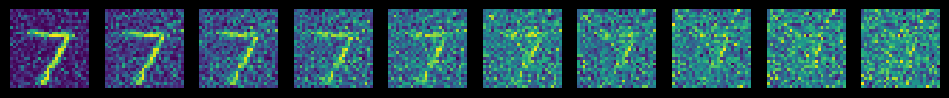

In [11]:
def diffuse(x: Tensor) -> Tensor:
    a = tch.rand_like(x)**noise_mag
    return a * x + (1.0 - a) * tch.rand_like(x)

x = make_images(test_images[0:1])
fig, axs = plt.subplots(1, n_steps)
for i in range(n_steps):
    x = diffuse(x)

    img = x.detach().cpu().numpy()[0]
    ax = axs[i]
    ax.axis('off')
    ax.imshow(img, interpolation='nearest')
fig.show()

In [12]:
def sample_fig(model: nn.Module, x: Tensor):
    model.train(False)

    fig, axs = plt.subplots(x.shape[0], n_steps)
    for col in range(n_steps):
        x = model.forward(x).sigmoid()
        
        images = x.detach().cpu().numpy()
        for row, img in enumerate(images):
            ax = axs[row, col]
            ax.axis('off')
            ax.imshow(img, interpolation='nearest')
        
    return fig

'epoch = 9'

{'loss': np.float64(0.533786099261426)}

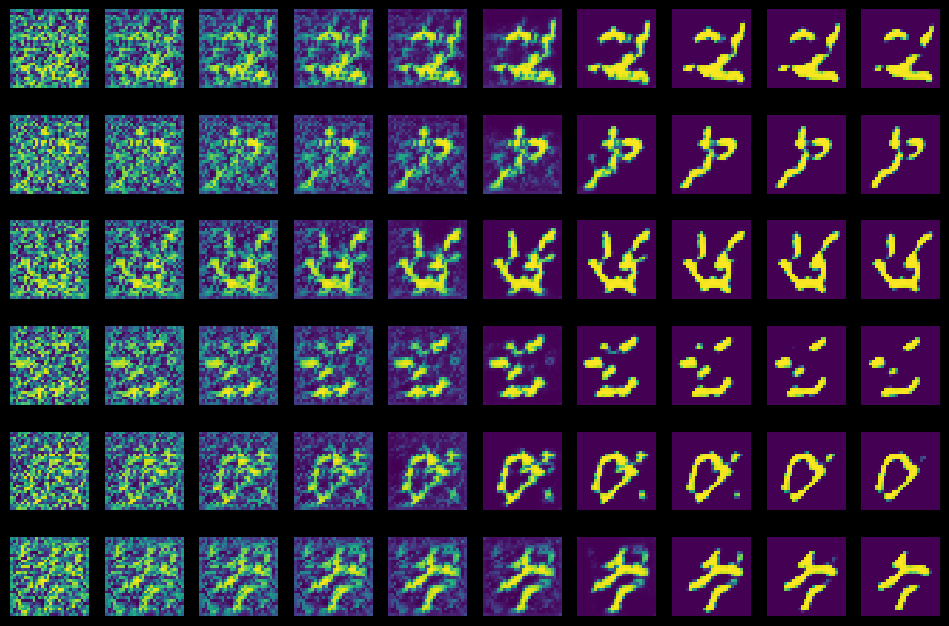

In [13]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.utils import Accum
from genpg.notebook import Display

display = Display()
test_x = tch.rand((6, *image_dims), device=dev)

for epoch in range(10):
    model.train(True)

    train_stats = Accum("loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        model.zero_grad()
        
        loss = tch.zeros((), device=dev)
        for _ in range(n_steps):
            y = images
            images = diffuse(images)
            x = images

            x = model.forward(x)

            loss += bce_with_logits(x, y, reduction="mean")
        loss /= n_steps

        loss.backward()
        optim.step()

        train_stats.append(loss.item())

    fig = sample_fig(model, test_x)

    display.clear()
    display.update(f"{epoch = }")
    display.update(train_stats.mean())
    display.update(fig)
    plt.close()



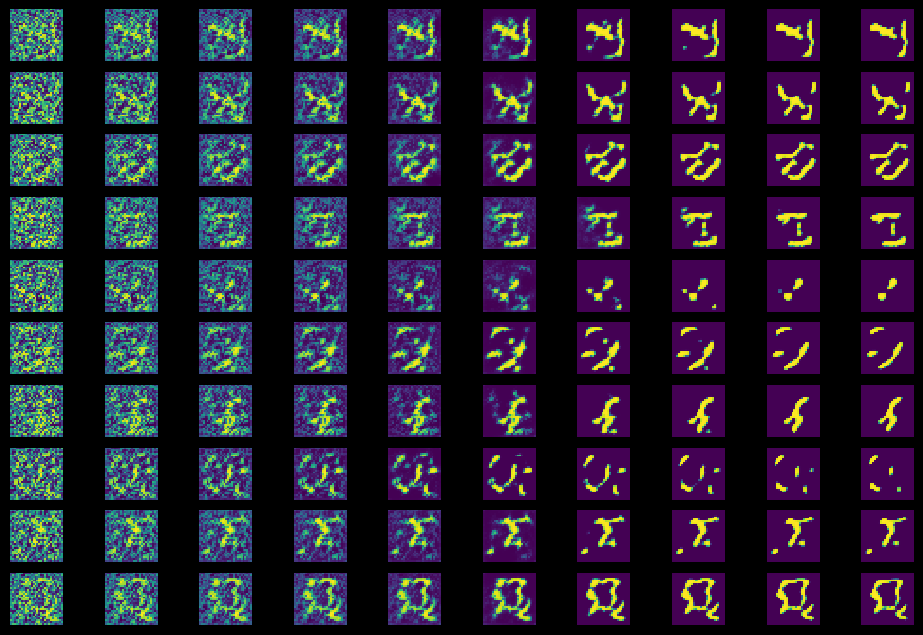

In [14]:
sample_fig(model, tch.rand((10, *image_dims), device=dev)).show()